# Basic function for road stats
## Yuwen Chang 2018/02/24

1. shortest
2. longest
3. straightest
4. curviest

In [1]:
import numpy as np
import pandas as pd
import pylab as pl

import osmnx as ox
import networkx as nx
import geopandas as gpd
from collections import Counter

from geopy import Nominatim
from geopy.distance import vincenty
from shapely.geometry import Point

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def road_stat(place, ntype='drive', timeout=10):
    """
    Find the straightest and curviest roads by name in a given geographical area in OSM.
    Find the shortest and longest roads by name in a given geographical area in OSM.
    
    Args:
        1. place: a string of place name
        2. ntype: network type (not tested yet)
    Return:
        1. name and length of the shortest road (length problem unsolved)
        2. name and length of the longest road (length problem unsolved)
        3. name and circuity info of the straightest road
        4. name and circuity info of the curviest road
        5. network graph plot of given place
    """
    
    # try different API query results
    n = 1
    while True:
        try:
            G = ox.graph_from_place(query=place, network_type=ntype, timeout=timeout, which_result=n)
            break
        except ValueError:
            n += 1
    #G = ox.project_graph(G)

    # save and read as .shp file
    ox.save_graph_shapefile(G, filename='temp_graph')
    G_edges = gpd.read_file('data/temp_graph/edges/edges.shp')
    G_nodes = gpd.read_file('data/temp_graph/nodes/nodes.shp')
    
    # > > > > > FUTURE: group by osmid instead of road name < < < < <
    
    # combine road segments
    G_edges.length = G_edges.length.astype('float')
    dict_v = {'length': 'sum', 'highway': 'first', 'oneway': 'first'}
    table = G_edges.groupby('name').agg(dict_v).reset_index()

    # calculate shortest and longest roads
    short = table.sort_values(by='length', ascending=True).head(1).iloc[0]
    long = table.sort_values(by='length', ascending=False).head(1).iloc[0]
    
    # extract road names
    roads = list(G_edges['name'].unique())
    roads.remove('') ### remove messy segements without names ###
    rnames = []
    dist_v = []
    dist_r = []
    circuity = []
    
    # calculate circuity for each road
    for i,r in enumerate(roads):
        df_road = G_edges[G_edges['name'] == roads[i]]
        nor = list(df_road['from'].values) + list(df_road['to'].values)
        tdict = dict(Counter(nor))
        tdf = pd.DataFrame(list(tdict.items()), columns=['node', 'count'])
        tdf_sub = tdf[tdf['count']==1]

        if len(tdf_sub) != 2:
            
            continue ### skip roads with more than two terminal nodes for now ###

        else:
            
            G_nodes_term = G_nodes[list(map(lambda n: n in list(tdf_sub['node'].values), list(G_nodes['osmid'])))]
            coord1 = list(G_nodes_term.iloc[0,:]['geometry'].coords)[0]
            coord2 = list(G_nodes_term.iloc[1,:]['geometry'].coords)[0]
            p1 = coord1[1], coord1[0]
            p2 = coord2[1], coord2[0]

            d_v = vincenty(p1, p2).meters
            d_r = df_road['length'].astype('float', error='coerce').sum()
            circ = d_r / d_v

            rnames.append(r)
            dist_v.append(d_v)
            dist_r.append(d_r)
            circuity.append(circ)

    # create a dataframe with circuity data
    df_circ = pd.DataFrame({'name': rnames,
                            'dist_v': dist_v,
                            'dist_r': dist_r,
                            'circuity': circuity})

    # calculate straightest and curviest roads
    straight = df_circ.sort_values('circuity', ascending=True).head(1).iloc[0]
    curve = df_circ.sort_values('circuity', ascending=False).head(1).iloc[0]
    
    # output
    print('Shortest road: {:s} ({:.2f} meters)'.format(short['name'], short['length']))
    print('Longest road: {:s} ({:.2f} meters)'.format(long['name'], long['length']))
    print('Straightest road: {:s}\nroad dist.: {:.2f}\nshortest dist.: {:.2f}\ncircuity: {:.5f}\n'.format(straight['name'], straight['dist_r'], straight['dist_v'], straight['circuity']))
    print('Curviest road: {:s}\nroad dist.: {:.2f}\nshortest dist.: {:.2f}\ncircuity: {:.5f}\n'.format(curve['name'], curve['dist_r'], curve['dist_v'], curve['circuity']))

    #ox.plot_graph(G);
    fig, ax = pl.subplots(figsize=(10,10))
    G_edges.plot(ax=ax)
    G_edges[G_edges['name'] == straight['name']].plot(color='green', ax=ax, label='straightest')
    G_edges[G_edges['name'] == curve['name']].plot(color='yellow', ax=ax, label='curviest')
    G_edges[G_edges['name'] == short['name']].plot(color='blue', ax=ax, label='shortest')
    G_edges[G_edges['name'] == long['name']].plot(color='red', ax=ax, label='longest')
    pl.legend(fontsize='medium')
    pl.show()

Shortest road: Highland Avenue (0.00 meters)
Longest road: University Avenue (0.02 meters)
Straightest road: Burbank Place
road dist.: 0.00
shortest dist.: 163.17
circuity: 0.00001

Curviest road: ['Sunset Drive', 'Blackhawk Drive']
road dist.: 0.00
shortest dist.: 136.93
circuity: 0.00002



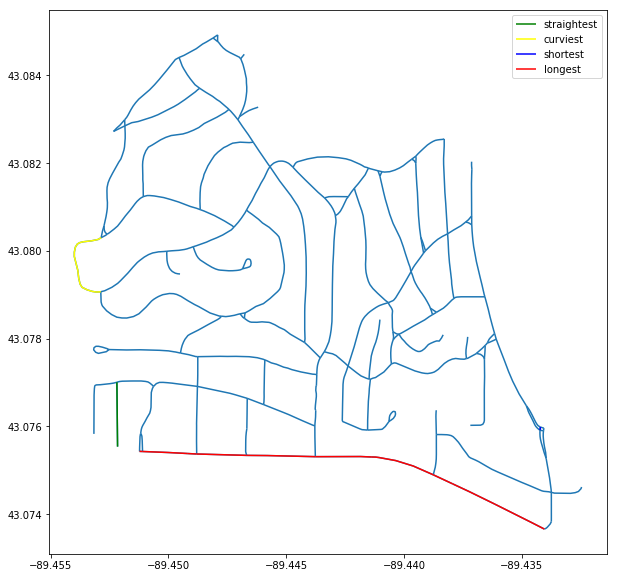

In [3]:
road_stat('Shorewood Hills, WI')

# Unmerged part

In [ ]:
santa_monica = ox.graph_from_place('Santa monica, Los Angeles County, California', network_type='drive')
santa_monica_projected = ox.project_graph(santa_monica)
fig, ax = ox.plot_graph(Boulder_projected)

In [ ]:
ox.save_graph_shapefile(santa_monica_projected, filename='santa_monica')
streets_sm = gpd.read_file('data/santa_monica/edges/edges.shp')
streets_sm.head()

In [ ]:
streets_sm.length = streets_sm.length.astype('float')
dict_v = {'length': 'sum', 'highway': 'first', 'oneway': 'first'}
table = streets_sm.groupby('name').agg(dict_v).reset_index()
table.head()
table.sort_values(by='length', ascending=False).head(10)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
streets_sm.plot(ax=ax, alpha=0.5)
streets_sm[streets_sm.name == 'Ocean Park Boulevard'].plot(ax=ax, color='black')
ax.set_title('Longest Drive in Santa Monica', fontsize=15)
ax.set_axis_off()

In [ ]:
geolocator = Nominatim()
location = geolocator.geocode("Ocean Park Boulevard, Santa monica, Los Angeles County, California")
print(location.address)
print(location.raw)

In [ ]:
table[table.length > 100].sort_values(by='length', ascending=True).head(10)

In [ ]:
def Download_graph(query, network_type='drive', timeout=10, return_n=False, draw=True):
    """
    Use osmnx.graph_from_place to download street network, 
    automatically select the result that return a polygon and visualize it.
    
    Parameters
    ----------
    query : string or dict or list
        the place(s) to geocode/download data for
    network_type : string
        what type of street network to get
    timeout : int
        the timeout interval for requests and to pass to API
    return_n : bool
        if True, return which result is selected
    draw : bool
        if True, plot the polygon
        
    Returns
    -------
    networkx multidigraph or networkx multidigraph and which_result as a tuple
    """
    
    n = 1
    while True:
        try:
            nw = ox.graph_from_place(query=query, network_type=network_type, timeout=timeout, which_result=n)
            break
        except ValueError:
            n += 1
    nw_p = ox.project_graph(nw)
    
    if draw:
        print(nx.info(nw_p))
        ox.plot_graph(nw_p, fig_height=10)
    
    if return_n:
        return (nw_p, n)
    else:
        return nw_p